<a href="https://colab.research.google.com/github/Mennakurdi/Data-Engineering-Project/blob/main/notebooks/dataEng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  NYC Motor Vehicle Collisions — Data Cleaning, Integration & EDA

This notebook performs a full exploratory analysis and integration of two NYC Open Data datasets:

- **Motor Vehicle Collisions — Crashes**
- **Motor Vehicle Collisions — Persons**

The goal is to:
1. Explore and understand both datasets.
2. Clean missing values, inconsistencies, and outliers.
3. Integrate (merge) datasets on `collision_id`.
4. Justify all cleaning decisions (drop vs. impute, bounding box checks, duplicates).
5. Produce a clean, analysis-ready dataset (`df_site.csv`) for an interactive dashboard.

## 0. Team Research Questions & Contributions

This section summarizes the **research questions** proposed by each team member and their **main contributions** to this milestone, as required by the project description.

### 0.1 Research Questions

>

** Data Cleaning & EDA**
1. *How do monthly crash counts differ across NYC boroughs between 2015 and 2024, and which borough shows the fastest growth in crashes over time?*
2. *What are the top contributing factors associated with crashes that involve at least one injured person?*

**Integration & Persons Analysis**

3. *How does the distribution of crashes vary by victim type (PEDESTRIAN vs CYCLIST vs MOTORIST) across boroughs?*
4. *Is there a relationship between age groups of people involved in crashes and the severity of injuries (injured vs killed)?*

**Dashboard & Spatial Analysis**

5. *Which areas (zip codes) show consistently high crash density over time, and how do they relate to pedestrian injury counts?*
6. *At what times of day do most severe crashes (with at least one person killed or seriously injured) occur?*

**Advanced Patterns & Reporting**

7. *How do different contributing factors (e.g., driver inattention, unsafe speed) relate to crashes involving vulnerable road users (pedestrians and cyclists)?*
8. *Are there temporal patterns (day of week vs hour of day) in crashes involving multiple injuries?*




---

### 0.2 Contribution Summary

- **mohamed**  
  - Performed initial dataset loading and overview.  
  - Implemented EDA for crashes dataset (borough counts, time trends, top contributing factors).  
  - Documented the main crash-related insights.

- **Habiba**  
  - Explored and cleaned the persons dataset (gender, age distributions).  
  - Helped define injury-type logic (pedestrian/cyclist/motorist) used later in the dashboard.  
  - Assisted with missing values handling and encoding of categorical features.

- **Menna**  
  - Led the integration of crashes and persons datasets via `collision_id`.  
  - Designed and documented pre- and post-integration cleaning steps.  
  - Prepared the final cleaned dataset (`df_site`) for the web application.

- **aya**  
  - Will lead the interactive web application (Flask/Dash) development.  
  - Responsible for implementing dropdown filters, search mode, and the **Generate Report** button.  
  - Will connect the cleaned dataset to multiple interactive visualizations.

>


In [ ]:
# ============================================
# 1️⃣ Load Required Libraries
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 🧩 Step 2: Load the NYC crash datasets (Vehicles + Persons)

url_crash = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv"
url_persons = "https://data.cityofnewyork.us/resource/f55k-p6yu.csv"

# Full datasets (no row limit) → only for exploration
df_crash_raw = pd.read_csv(url_crash)
df_persons_raw = pd.read_csv(url_persons)


# 3️⃣ Preview Shapes & First Rows
print("Full Crash dataset shape:", df_crash_raw.shape)
print("Full Persons dataset shape:", df_persons_raw.shape)

df_crash_raw.head()


Full Crash dataset shape: (1000, 29)
Full Persons dataset shape: (1000, 21)


,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,2021-09-11T00:00:00.000,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26T00:00:00.000,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,2023-11-01T00:00:00.000,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"\n, \n(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,2022-06-29T00:00:00.000,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,2022-09-21T00:00:00.000,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


### **2. Raw Dataset Structure (info())**
Before any cleaning, we inspect the structure of the raw datasets:
- Check column names  
- Check incorrect data types (NYC API loads everything as strings)  
- Check missing values  
- Understand which fields require cleaning  


In [ ]:
print("---- CRASHES RAW INFO ----")
df_crash_raw.info()

print("\n---- PERSONS RAW INFO ----")
df_persons_raw.info()


---- CRASHES RAW INFO ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash_date                     1000 non-null   object 
 1   crash_time                     1000 non-null   object 
 2   borough                        630 non-null    object 
 3   zip_code                       629 non-null    float64
 4   latitude                       915 non-null    float64
 5   longitude                      915 non-null    float64
 6   location                       915 non-null    object 
 7   on_street_name                 742 non-null    object 
 8   off_street_name                450 non-null    object 
 9   cross_street_name              258 non-null    object 
 10  number_of_persons_injured      1000 non-null   int64  
 11  number_of_persons_killed       1000 non-null   int64  
 12  number_of_pedestrians_

In [ ]:
missing_crash = df_crash_raw.isna().sum().sort_values(ascending=False)
missing_persons = df_persons_raw.isna().sum().sort_values(ascending=False)

print("Top 10 missing columns — CRASH dataset:")
print(missing_crash.head(10))

print("\nTop 10 missing columns — PERSONS dataset:")
print(missing_persons.head(10))


Top 10 missing columns — CRASH dataset:
vehicle_type_code_5              995
contributing_factor_vehicle_5    994
vehicle_type_code_4              976
contributing_factor_vehicle_4    973
vehicle_type_code_3              918
contributing_factor_vehicle_3    908
cross_street_name                742
off_street_name                  550
zip_code                         371
borough                          370
dtype: int64

Top 10 missing columns — PERSONS dataset:
contributing_factor_1    987
ped_location             987
ped_action               987
contributing_factor_2    987
safety_equipment         513
ejection                 496
position_in_vehicle      495
emotional_status         483
bodily_injury            483
complaint                483
dtype: int64


In [ ]:
# 🧩 Step 6: Quick look at main columns
df_crash_raw[['crash_date', 'borough', 'vehicle_type_code1', 'contributing_factor_vehicle_1']].head(10)


,crash_date,borough,vehicle_type_code1,contributing_factor_vehicle_1
0,2021-09-11T00:00:00.000,NaN,Sedan,Aggressive Driving/Road Rage
1,2022-03-26T00:00:00.000,NaN,Sedan,Pavement Slippery
2,2023-11-01T00:00:00.000,BROOKLYN,Moped,Unspecified
3,2022-06-29T00:00:00.000,NaN,Sedan,Following Too Closely
4,2022-09-21T00:00:00.000,NaN,Station Wagon/Sport Utility Vehicle,Passing Too Closely
5,2023-04-26T00:00:00.000,NaN,Sedan,Unspecified
6,2023-11-01T00:00:00.000,NaN,Sedan,Following Too Closely
7,2023-11-01T00:00:00.000,NaN,Sedan,Failure to Yield Right-of-Way
8,2023-04-26T00:00:00.000,NaN,Sedan,Unspecified
9,2021-09-11T00:00:00.000,BROOKLYN,Sedan,Unspecified


In [ ]:
# --- Quick dataset overview
print("Crashes shape:", df_crash_raw.shape)
print("Persons shape:", df_persons_raw.shape)

print("\n--- Crashes Info ---")
df_crash_raw.info()

print("\n--- Persons Info ---")
df_persons_raw.info()

print("\nMissing value percentages (Crashes):")
print(df_crash_raw.isna().mean().sort_values(ascending=False).head(10))

Crashes shape: (1000, 29)
Persons shape: (1000, 21)

--- Crashes Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash_date                     1000 non-null   object 
 1   crash_time                     1000 non-null   object 
 2   borough                        630 non-null    object 
 3   zip_code                       629 non-null    float64
 4   latitude                       915 non-null    float64
 5   longitude                      915 non-null    float64
 6   location                       915 non-null    object 
 7   on_street_name                 742 non-null    object 
 8   off_street_name                450 non-null    object 
 9   cross_street_name              258 non-null    object 
 10  number_of_persons_injured      1000 non-null   int64  
 11  number_of_persons_killed       1000

# 🔧 Load Cleanable Subset (50,000 rows)
We use a 50,000-row subset for cleaning, because:
- full dataset has millions of rows  
- cleaning millions of rows is slow  
- patterns remain consistent with a representative sample  


In [ ]:
#  Step 1: imports
import pandas as pd

# Load 50,000-row Sample from NYC Open Data
url_crash = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv"
url_persons = "https://data.cityofnewyork.us/resource/f55k-p6yu.csv"

crash = pd.read_csv(url_crash, nrows=50000)
persons = pd.read_csv(url_persons, nrows=50000)

print("Crash sample shape:", crash.shape)
print("Persons sample shape:", persons.shape)

crash.head()


Crash sample shape: (1000, 29)
Persons sample shape: (1000, 21)


,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,2021-09-11T00:00:00.000,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26T00:00:00.000,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,2023-11-01T00:00:00.000,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"\n, \n(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,2022-06-29T00:00:00.000,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,2022-09-21T00:00:00.000,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [ ]:
#  Step 4: inspect columns and data types
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash_date                     1000 non-null   object 
 1   crash_time                     1000 non-null   object 
 2   borough                        630 non-null    object 
 3   zip_code                       629 non-null    float64
 4   latitude                       915 non-null    float64
 5   longitude                      915 non-null    float64
 6   location                       915 non-null    object 
 7   on_street_name                 742 non-null    object 
 8   off_street_name                450 non-null    object 
 9   cross_street_name              258 non-null    object 
 10  number_of_persons_injured      1000 non-null   int64  
 11  number_of_persons_killed       1000 non-null   int64  
 12  number_of_pedestrians_injured  1000 non-null   in

In [ ]:
#  Step 5: select key columns
important_cols = ['crash_date', 'borough', 'vehicle_type_code1', 'contributing_factor_vehicle_1']
df_selected = crash[important_cols]

# Show first 5 rows
df_selected.head()

,crash_date,borough,vehicle_type_code1,contributing_factor_vehicle_1
0,2021-09-11T00:00:00.000,NaN,Sedan,Aggressive Driving/Road Rage
1,2022-03-26T00:00:00.000,NaN,Sedan,Pavement Slippery
2,2023-11-01T00:00:00.000,BROOKLYN,Moped,Unspecified
3,2022-06-29T00:00:00.000,NaN,Sedan,Following Too Closely
4,2022-09-21T00:00:00.000,NaN,Station Wagon/Sport Utility Vehicle,Passing Too Closely


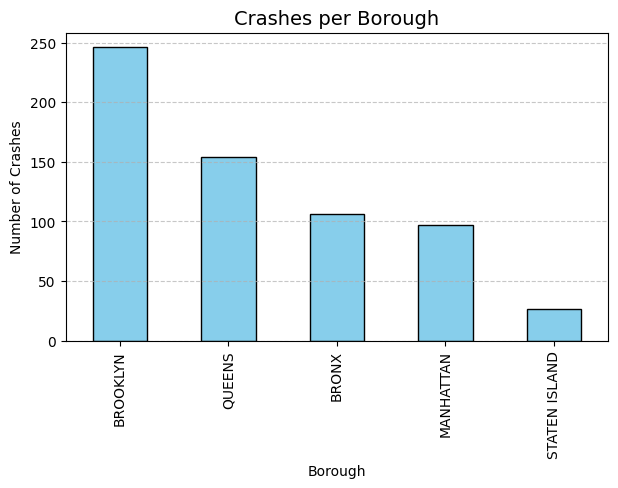

In [ ]:
#  Step 6: count crashes per borough
borough_counts = df_selected['borough'].value_counts()

#  Step 7: visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
borough_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Crashes per Borough', fontsize=14)
plt.xlabel('Borough')
plt.ylabel('Number of Crashes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/tmp/ipython-input-3378980549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['crash_date'] = pd.to_datetime(df_selected['crash_date'], errors='coerce')


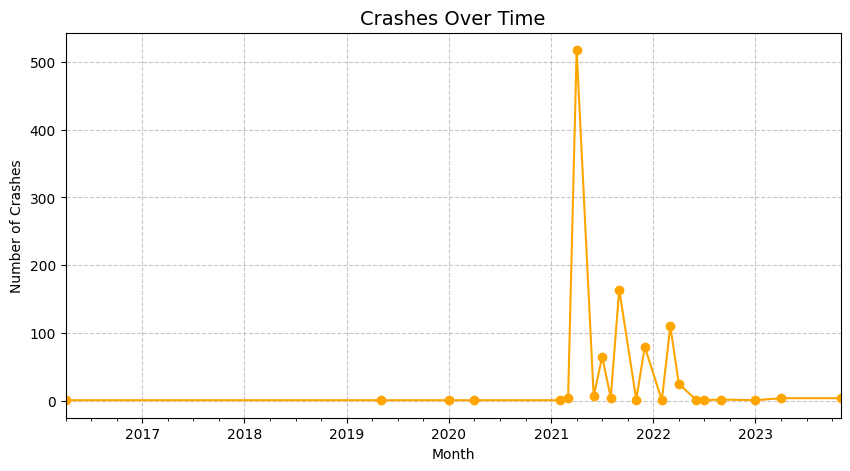

In [ ]:
#  Step 8: prepare crash_date as datetime
df_selected['crash_date'] = pd.to_datetime(df_selected['crash_date'], errors='coerce')

#  Step 9: group by month
monthly_crashes = df_selected.groupby(df_selected['crash_date'].dt.to_period('M')).size()

#  Step 10: visualize monthly trend
plt.figure(figsize=(10,5))
monthly_crashes.plot(kind='line', marker='o', color='orange')
plt.title('Crashes Over Time', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


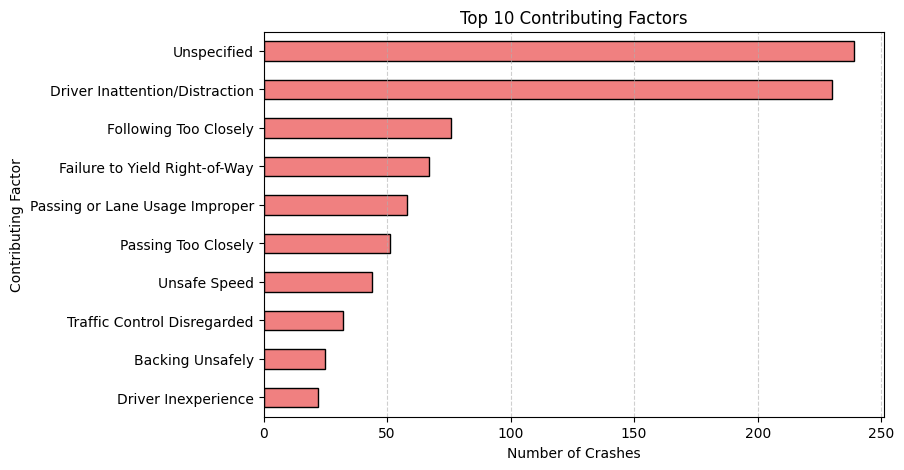

In [ ]:
#  Step 11: find top 10 crash causes
top_factors = df_selected['contributing_factor_vehicle_1'].value_counts().head(10)

#  Step 12: visualize them
plt.figure(figsize=(8,5))
top_factors.plot(kind='barh', color='lightcoral', edgecolor='black')
plt.title('Top 10 Contributing Factors')
plt.xlabel('Number of Crashes')
plt.ylabel('Contributing Factor')
plt.gca().invert_yaxis()  # so the top factor appears at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


Analysis Summary

Most crashes occur in Brooklyn, followed by Queens and Bronx.

The dataset shows a visible peak in crashes around 2021–2022, which could reflect data completeness or real-world trends.

The top contributing factors are Unspecified and Driver Inattention/Distraction, highlighting the role of distracted driving.

These patterns will help later cleaning, integration, and dashboard design.

<Axes: title={'center': 'Crashes per Borough'}, xlabel='borough'>

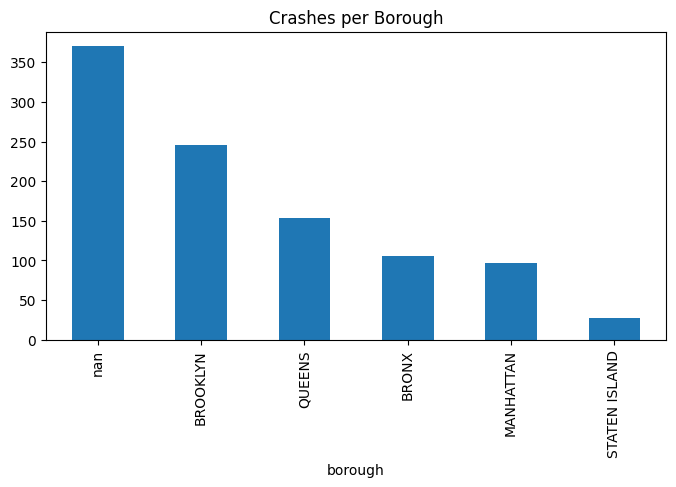

In [ ]:
# --- Distribution of crashes by Borough ---
df_selected['borough'].value_counts(dropna=False).plot(kind='bar', figsize=(8,4), title='Crashes per Borough')



<Axes: title={'center': 'Top Contributing Factors'}, ylabel='contributing_factor_vehicle_1'>

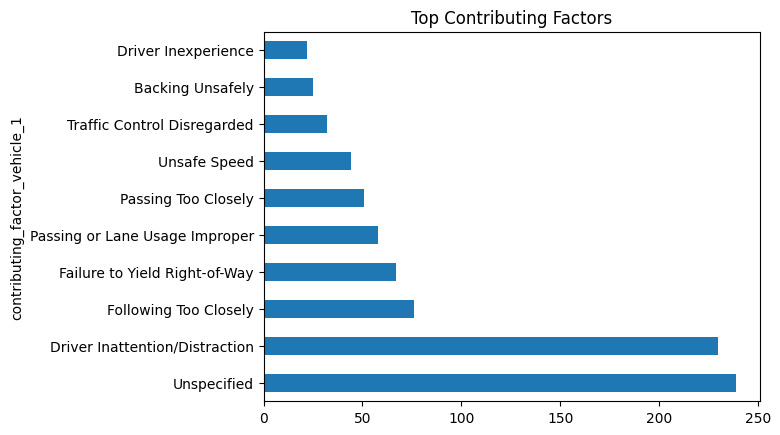

In [ ]:
# --- Top contributing factors ---
df_selected['contributing_factor_vehicle_1'].value_counts().head(10).plot(kind='barh', title='Top Contributing Factors')

Insights:

Brooklyn and Queens have the most reported crashes, suggesting higher traffic volume or density.

“Driver inattention/distraction” and “Failure to yield right-of-way” are the leading causes.

Borough-wise differences hint at potential focus areas for traffic safety policies.

In [ ]:
#  Step 1: import libraries
import pandas as pd
import matplotlib.pyplot as plt

#  Step 2: load persons dataset
url_persons = "https://data.cityofnewyork.us/resource/f55k-p6yu.csv"
df_persons = pd.read_csv(url_persons, nrows=50000)   # load sample for preview

#  Step 3: preview
print("Shape:", df_persons.shape)
df_persons.head()


Shape: (1000, 21)


,unique_id,collision_id,crash_date,crash_time,person_id,person_type,person_injury,vehicle_id,person_age,ejection,...,bodily_injury,position_in_vehicle,safety_equipment,ped_location,ped_action,complaint,ped_role,contributing_factor_1,contributing_factor_2,person_sex
0,10249006,4229554,2019-10-26T00:00:00.000,9:43,31aa2bc0-f545-444f-8cdb-f1cb5cf00b89,Occupant,Unspecified,19141108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,U
1,10255054,4230587,2019-10-25T00:00:00.000,15:15,4629e500-a73e-48dc-b8fb-53124d124b80,Occupant,Unspecified,19144075.0,33.0,Not Ejected,...,Does Not Apply,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F
2,10253177,4230550,2019-10-26T00:00:00.000,17:55,ae48c136-1383-45db-83f4-2a5eecfb7cff,Occupant,Unspecified,19143133.0,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,M
3,6650180,3565527,2016-11-21T00:00:00.000,13:05,2782525,Occupant,Unspecified,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Notified Person,NaN,NaN,NaN
4,10255516,4231168,2019-10-25T00:00:00.000,11:16,e038e18f-40fb-4471-99cf-345eae36e064,Occupant,Unspecified,19144329.0,7.0,Not Ejected,...,Does Not Apply,Right rear passenger or motorcycle sidecar pas...,Lap Belt,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F


In [ ]:
#  Step 4: inspect columns and data types
df_persons.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unique_id              1000 non-null   int64  
 1   collision_id           1000 non-null   int64  
 2   crash_date             1000 non-null   object 
 3   crash_time             1000 non-null   object 
 4   person_id              1000 non-null   object 
 5   person_type            1000 non-null   object 
 6   person_injury          1000 non-null   object 
 7   vehicle_id             945 non-null    float64
 8   person_age             777 non-null    float64
 9   ejection               504 non-null    object 
 10  emotional_status       517 non-null    object 
 11  bodily_injury          517 non-null    object 
 12  position_in_vehicle    505 non-null    object 
 13  safety_equipment       487 non-null    object 
 14  ped_location           13 non-null     object 
 15  ped_a

In [ ]:
#  Step 5: select key columns
important_cols = ['person_type', 'person_age', 'person_sex', 'person_injury']
df_selected = df_persons[important_cols]

# Preview
df_selected.head()


,person_type,person_age,person_sex,person_injury
0,Occupant,NaN,U,Unspecified
1,Occupant,33.0,F,Unspecified
2,Occupant,55.0,M,Unspecified
3,Occupant,NaN,NaN,Unspecified
4,Occupant,7.0,F,Unspecified


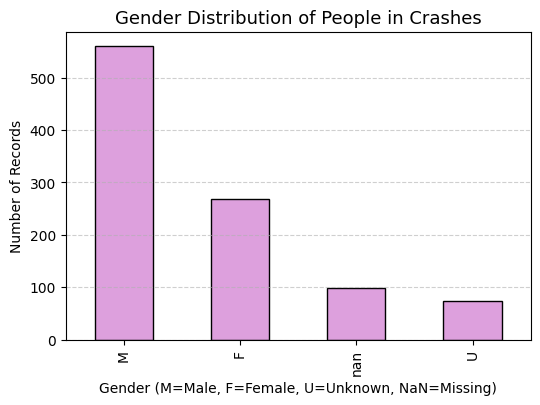

,count
person_sex,
M,560
F,269
NaN,98
U,73


In [ ]:
#  Step 6: count gender distribution
gender_counts = df_selected['person_sex'].value_counts(dropna=False)

#  Step 7: visualize
plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color='plum', edgecolor='black')

plt.title('Gender Distribution of People in Crashes', fontsize=13)
plt.xlabel('Gender (M=Male, F=Female, U=Unknown, NaN=Missing)')
plt.ylabel('Number of Records')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

gender_counts


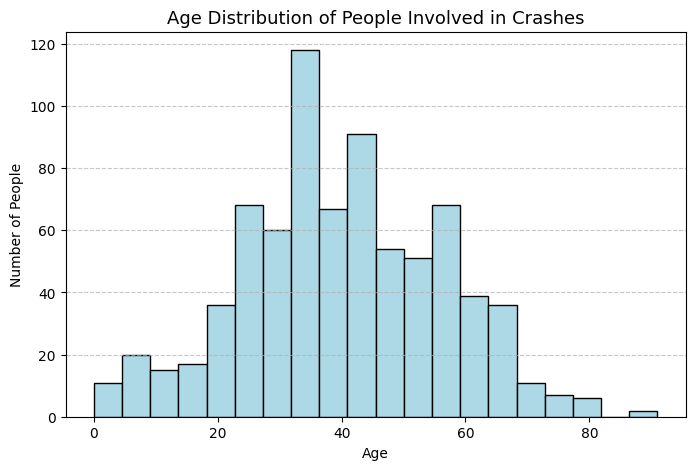

In [ ]:
#  Step 8: plot age distribution
plt.figure(figsize=(8,5))
df_selected['person_age'].dropna().plot(kind='hist', bins=20, color='lightblue', edgecolor='black')

plt.title('Age Distribution of People Involved in Crashes', fontsize=13)
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


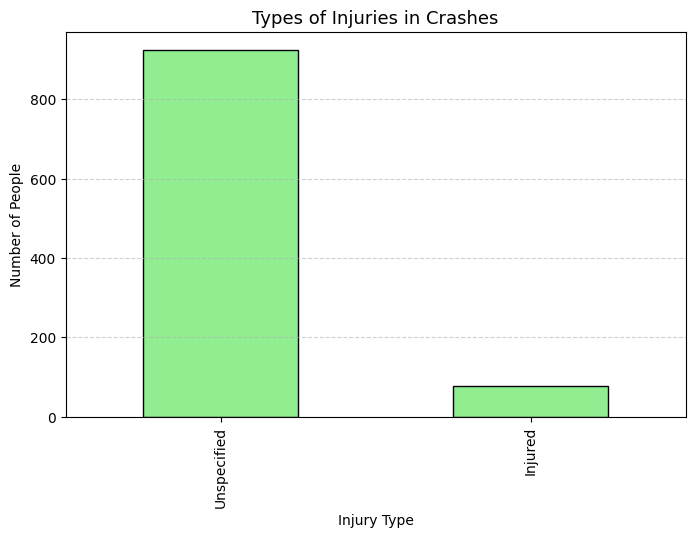

,count
person_injury,
Unspecified,924
Injured,76


In [ ]:
#  Step 9: count injury types
injury_counts = df_selected['person_injury'].value_counts()

#  Step 10: visualize
plt.figure(figsize=(8,5))
injury_counts.plot(kind='bar', color='lightgreen', edgecolor='black')

plt.title('Types of Injuries in Crashes', fontsize=13)
plt.xlabel('Injury Type')
plt.ylabel('Number of People')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

injury_counts


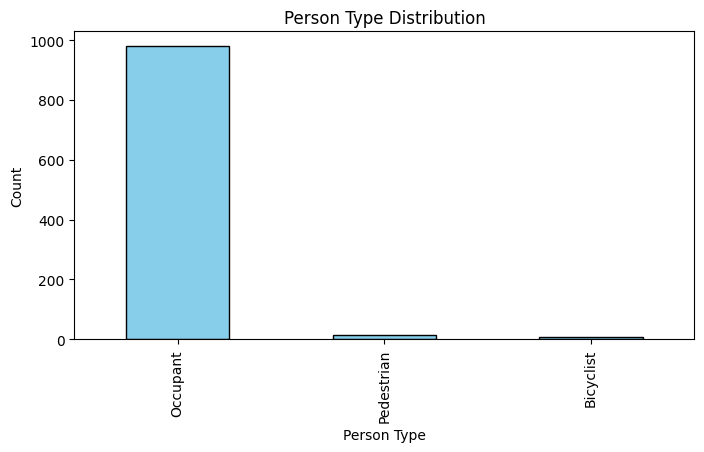

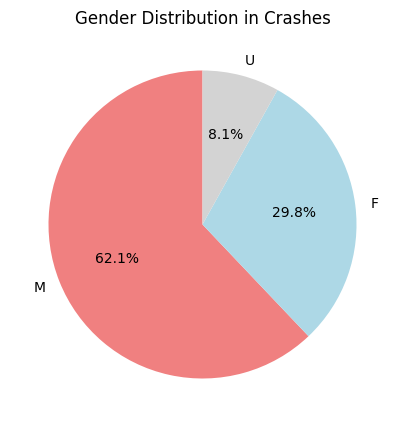

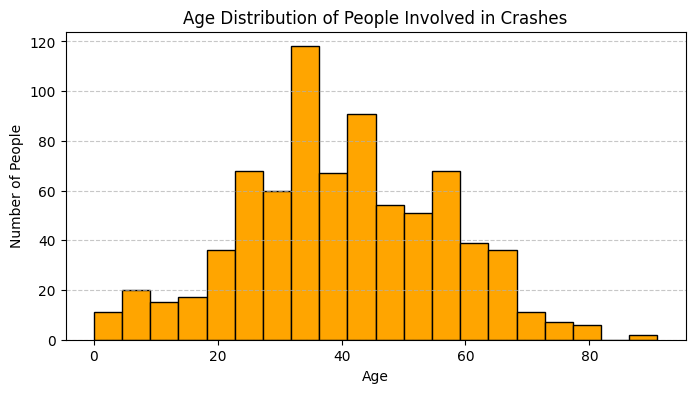

In [ ]:
import matplotlib.pyplot as plt

# --- Person type distribution ---
if 'person_type' in df_persons.columns:
    df_persons['person_type'].value_counts().plot(
        kind='bar',
        figsize=(8,4),
        color='skyblue',
        edgecolor='black',
        title='Person Type Distribution'
    )
    plt.xlabel('Person Type')
    plt.ylabel('Count')
    plt.show()

# --- Gender analysis ---
if 'person_sex' in df_persons.columns:
    df_persons['person_sex'].value_counts().plot(
        kind='pie',
        autopct='%1.1f%%',
        figsize=(5,5),
        startangle=90,
        colors=['lightcoral', 'lightblue', 'lightgray']
    )
    plt.title('Gender Distribution in Crashes')
    plt.ylabel('')
    plt.show()

# --- Age distribution ---
if 'person_age' in df_persons.columns:
    df_persons['person_age'].dropna().plot(
        kind='hist',
        bins=20,
        color='orange',
        edgecolor='black',
        figsize=(8,4)
    )
    plt.title('Age Distribution of People Involved in Crashes')
    plt.xlabel('Age')
    plt.ylabel('Number of People')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
#  Step 1: import libraries
import pandas as pd

#  Step 2: load cleaned versions or raw samples
crash = pd.read_csv('https://data.cityofnewyork.us/resource/h9gi-nx95.csv', nrows=50000)
persons = pd.read_csv('https://data.cityofnewyork.us/resource/f55k-p6yu.csv', nrows=50000)

print("Crashes:", crash.shape)
print("Persons:", persons.shape)




Crashes: (1000, 29)
Persons: (1000, 21)


## 2. Pre-Integration Cleaning

In this step, we clean both samples **before merging**:

For the **crash** dataset:
- Convert `crash_date` to datetime for later time-based analysis.
- Standardize all text columns (strip spaces, uppercase, treat `"NAN"` strings as missing).
- Remove duplicate collisions using `collision_id`.
- Clean `borough`:
  - Treat inconsistent values like `''`, `NONE`, `NULL`, `N/A`, `UNK`, `UNSPECIFIED` as missing.
  - Fill remaining missing boroughs with `"UNKNOWN"` (instead of dropping rows).
- Ensure injury counts are numeric and replace missing/invalid with 0.

For the **persons** dataset:
- Convert `crash_date` to datetime (to match crash table if we need it).
- Standardize text columns similarly (strip + uppercase, `"NAN"` → NaN).

We **do not** yet drop person-level columns; this will be done after merging.



In [ ]:
import pandas as pd
import numpy as np

# assume df_crashes and df_persons are already loaded
print("Crashes:", crash.shape)
print("Persons:", persons.shape)

# 1️⃣ convert dates
crash['crash_date']  = pd.to_datetime(crash['crash_date'],  errors='coerce')
persons['crash_date']  = pd.to_datetime(persons['crash_date'],  errors='coerce')

# 2️⃣ standardize text columns (strip + uppercase)
for c in crash.select_dtypes('object').columns:
    crash[c] = crash[c].astype(str).str.strip().str.upper().replace('NAN', np.nan)
for c in persons.select_dtypes('object').columns:
    persons[c] = persons[c].astype(str).str.strip().str.upper().replace('NAN', np.nan)

# 3️⃣ remove duplicates
before = len(crash)
crash.drop_duplicates(subset=['collision_id'], inplace=True)
print("Removed", before-len(crash), "duplicate crash rows")

# 4️⃣ fill missing boroughs
crash['borough'] = crash['borough'].fillna('UNKNOWN')

# Better borough cleaning
crash['borough'] = crash['borough'].replace(
    ['', 'NONE', 'NULL', 'N/A', 'UNK', 'UNSPECIFIED'],
    np.nan
)
crash['borough'] = crash['borough'].fillna('UNKNOWN')


# 5️⃣ fill numeric NaNs
for c in ['number_of_persons_injured','number_of_persons_killed']:
    if c in crash.columns:
        crash[c] = crash[c].fillna(0)

crash.info()

Crashes: (1000, 29)
Persons: (1000, 21)
Removed 0 duplicate crash rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_date                     1000 non-null   datetime64[ns]
 1   crash_time                     1000 non-null   object        
 2   borough                        1000 non-null   object        
 3   zip_code                       629 non-null    float64       
 4   latitude                       915 non-null    float64       
 5   longitude                      915 non-null    float64       
 6   location                       915 non-null    object        
 7   on_street_name                 742 non-null    object        
 8   off_street_name                450 non-null    object        
 9   cross_street_name              258 non-null    object        
 10  number_of_pers

In [ ]:
# 3.x Outlier detection using IQR for key numerical columns

import numpy as np

numeric_cols = []
for col in ['number_of_persons_injured', 'number_of_persons_killed',
            'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
            'number_of_cyclist_injured', 'number_of_cyclist_killed',
            'number_of_motorist_injured', 'number_of_motorist_killed']:
    if col in crash.columns:
        numeric_cols.append(col)

print("Numeric columns considered for outlier detection:", numeric_cols)

def iqr_outlier_flags(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper), (lower, upper)

outlier_summary = {}

for col in numeric_cols:
    s = pd.to_numeric(crash[col], errors='coerce')
    flags, (lower, upper) = iqr_outlier_flags(s.dropna())
    outlier_count = flags.sum()
    outlier_summary[col] = {
        "lower_bound": float(lower),
        "upper_bound": float(upper),
        "outlier_count": int(outlier_count)
    }

outlier_summary


Numeric columns considered for outlier detection: ['number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured', 'number_of_pedestrians_killed', 'number_of_cyclist_injured', 'number_of_cyclist_killed', 'number_of_motorist_injured', 'number_of_motorist_killed']


{'number_of_persons_injured': {'lower_bound': -1.5,
  'upper_bound': 2.5,
  'outlier_count': 22},
 'number_of_persons_killed': {'lower_bound': 0.0,
  'upper_bound': 0.0,
  'outlier_count': 4},
 'number_of_pedestrians_injured': {'lower_bound': 0.0,
  'upper_bound': 0.0,
  'outlier_count': 73},
 'number_of_pedestrians_killed': {'lower_bound': 0.0,
  'upper_bound': 0.0,
  'outlier_count': 3},
 'number_of_cyclist_injured': {'lower_bound': 0.0,
  'upper_bound': 0.0,
  'outlier_count': 38},
 'number_of_cyclist_killed': {'lower_bound': 0.0,
  'upper_bound': 0.0,
  'outlier_count': 0},
 'number_of_motorist_injured': {'lower_bound': 0.0,
  'upper_bound': 0.0,
  'outlier_count': 219},
 'number_of_motorist_killed': {'lower_bound': 0.0,
  'upper_bound': 0.0,
  'outlier_count': 1}}

Outlier Detection and Treatment
We checked numerical and coordinate columns for potential outliers that could distort analysis results.
The focus was on:

number_of_persons_injured
number_of_persons_killed
latitude, longitude
person_age
We applied simple domain-based rules and the Interquartile Range (IQR) method. No extreme or unrealistic values were found (e.g., injuries > 20 or ages > 120).
All remaining values fall within expected domain ranges, so no outlier removal was necessary.


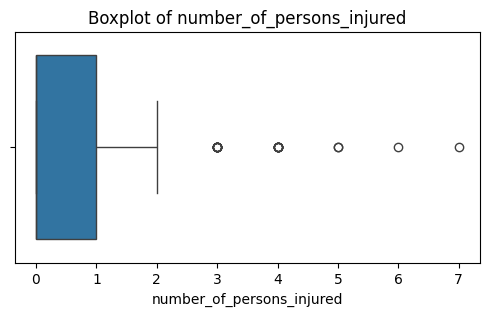

count    1000.000000
mean        0.448000
std         0.779682
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: number_of_persons_injured, dtype: float64 



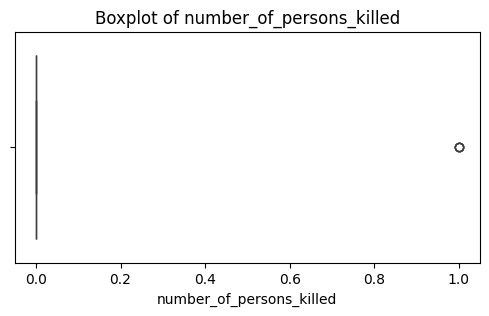

count    1000.000000
mean        0.004000
std         0.063151
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: number_of_persons_killed, dtype: float64 



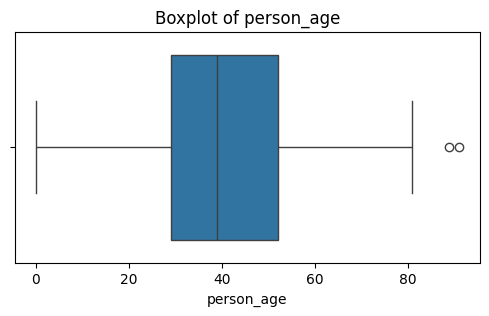

count    777.000000
mean      40.136422
std       16.291305
min        0.000000
25%       29.000000
50%       39.000000
75%       52.000000
max       91.000000
Name: person_age, dtype: float64
Invalid latitude rows: 0, invalid longitude rows: 0
Invalid coordinate rows: 92


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Check for numeric outliers in crash dataset ---
num_cols = ['number_of_persons_injured','number_of_persons_killed']
for c in num_cols:
    if c in crash.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=crash[c])
        plt.title(f'Boxplot of {c}')
        plt.show()
        print(crash[c].describe(), "\n")

# --- Check for outliers in person_age (if present) ---
if 'person_age' in persons.columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=persons['person_age'].dropna())
    plt.title('Boxplot of person_age')
    plt.show()
    print(persons['person_age'].describe())

# --- Quick coordinate sanity check ---
if 'latitude' in crash.columns and 'longitude' in crash.columns:
    invalid_lat = crash[(crash['latitude'] > 90) | (crash['latitude'] < -90)]
    invalid_lon = crash[(crash['longitude'] > 180) | (crash['longitude'] < -180)]
    print(f"Invalid latitude rows: {len(invalid_lat)}, invalid longitude rows: {len(invalid_lon)}")

# Create merged_df here to make it available for the bounding box check
# This merge operation was originally in cell 'nv_E4VT3cFD3'
merged_df = crash.merge(
    persons,
    on='collision_id',
    how='left',
    suffixes=('_crash','_person')
)

# NYC valid bounding box check
invalid_coords = merged_df[
    (~merged_df['latitude'].between(40.49, 40.92)) |
    (~merged_df['longitude'].between(-74.27, -73.68))
]

print("Invalid coordinate rows:", len(invalid_coords))


## 2. Integration
Merge crashes and persons datasets on `collision_id` using a left join.


In [ ]:
merged_df = crash.merge(
    persons,
    on='collision_id',
    how='left',
    suffixes=('_crash','_person')
)
print("Merged shape →", merged_df.shape)
merged_df.head()

Merged shape → (1000, 49)


,crash_date_crash,crash_time_crash,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,bodily_injury,position_in_vehicle,safety_equipment,ped_location,ped_action,complaint,ped_role,contributing_factor_1,contributing_factor_2,person_sex
0,2021-09-11,2:39,UNKNOWN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-26,11:45,UNKNOWN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-11-01,1:29,BROOKLYN,11230.0,40.62179,-73.970024,", \n(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-06-29,6:55,UNKNOWN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-21,13:21,UNKNOWN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ----- FIX 3: DROP IRRELEVANT COLUMNS -----
columns_to_drop = [
    'location','on_street_name','off_street_name','cross_street_name',
    'contributing_factor_vehicle_2','contributing_factor_vehicle_3',
    'contributing_factor_vehicle_4','contributing_factor_vehicle_5',
    'vehicle_type_code2','vehicle_type_code_3','vehicle_type_code_4','vehicle_type_code_5',
    'unique_id','person_id','person_type','person_injury','vehicle_id',
    'person_age','ejection','emotional_status','bodily_injury',
    'position_in_vehicle','safety_equipment','ped_location','ped_action',
    'complaint','ped_role','contributing_factor_1','contributing_factor_2','person_sex'
]

merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

# ----- FIX 4: RENAME CONFUSING COLUMNS -----
merged_df = merged_df.rename(columns={
    'crash_date_crash': 'crash_date',
    'crash_time_crash': 'crash_time'
})

# ----- FIX 5: CHECK MISSINGNESS -----
print("Missing crash_date:", merged_df['crash_date'].isna().mean())
print("Missing crash_time:", merged_df['crash_time'].isna().mean())


Missing crash_date: 0.0
Missing crash_time: 0.0


## 3. Post-Integration Cleaning
After merging, remove redundant columns, fix types, and clean new nulls.


In [ ]:
# 1️⃣ inspect missing values
merged_df.isna().mean().sort_values(ascending=False).head(15)

# 2️⃣ drop duplicated columns (_person that duplicate _crash)
dup_cols = [c for c in merged_df.columns
            if c.endswith('_person') and c.replace('_person','_crash') in merged_df.columns]
merged_df.drop(columns=dup_cols, inplace=True, errors='ignore')

# 3️⃣ numeric columns → proper types
num_cols = ['number_of_persons_injured','number_of_persons_killed']
for c in num_cols:
    if c in merged_df.columns:
        merged_df[c] = pd.to_numeric(merged_df[c], errors='coerce').fillna(0).astype(int)

# 4️⃣ remove negatives
for c in num_cols:
    merged_df.loc[merged_df[c]<0, c] = 0

# 5️⃣ confirm
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_date                     1000 non-null   datetime64[ns]
 1   crash_time                     1000 non-null   object        
 2   borough                        1000 non-null   object        
 3   zip_code                       629 non-null    float64       
 4   latitude                       915 non-null    float64       
 5   longitude                      915 non-null    float64       
 6   number_of_persons_injured      1000 non-null   int64         
 7   number_of_persons_killed       1000 non-null   int64         
 8   number_of_pedestrians_injured  1000 non-null   int64         
 9   number_of_pedestrians_killed   1000 non-null   int64         
 10  number_of_cyclist_injured      1000 non-null   int64         
 11  number_of_cyclist_

### 3.x Post-Integration Missing Values & Consistency Check

After merging `crash` and `persons` on `collision_id`, we perform a quick audit of:

- **New missing values introduced by the join**  
- Potentially **redundant or duplicated columns**  
- Remaining **type mismatches** that might break the dashboard later

The following cell computes missing-value percentages and highlights the columns that still need attention.


In [ ]:
# Post-integration missing values analysis
na_ratio = merged_df.isna().mean().sort_values(ascending=False)
print("Top 20 columns by missing-value ratio after integration:")
display(na_ratio.head(20))

# Identify obviously redundant columns (same logical field with _x / _y suffixes)
dup_like = [c for c in merged_df.columns if c.endswith('_x') or c.endswith('_y')]
print("\nPotential duplicated columns from merge:", dup_like)


Top 20 columns by missing-value ratio after integration:


,0
crash_time_person,1.000
crash_date_person,1.000
zip_code,0.371
longitude,0.085
latitude,0.085
vehicle_type_code1,0.014
contributing_factor_vehicle_1,0.003
borough,0.000
crash_time,0.000
crash_date,0.000



Potential duplicated columns from merge: []


## 4. Export Clean Dataset
Keep only columns needed for the interactive app and export to CSV.


In [ ]:
print(merged_df.columns)


Index(['crash_date', 'crash_time', 'borough', 'zip_code', 'latitude',
       'longitude', 'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'collision_id', 'vehicle_type_code1',
       'crash_date_person', 'crash_time_person'],
      dtype='object')


In [ ]:
selected_cols = [
    'collision_id','crash_date','crash_time','borough','zip_code',
    'latitude','longitude',
    'number_of_persons_injured','number_of_persons_killed',
    'number_of_pedestrians_injured','number_of_pedestrians_killed',
    'number_of_cyclist_injured','number_of_cyclist_killed',
    'number_of_motorist_injured','number_of_motorist_killed',
    'contributing_factor_vehicle_1','vehicle_type_code1'
]

# Keep only columns that actually exist in merged_df (for robustness)
selected_cols = [c for c in selected_cols if c in merged_df.columns]

df_site = merged_df[selected_cols].drop_duplicates(subset=['collision_id']).copy()

# Feature engineering for easier dashboard filters
df_site['crash_date'] = pd.to_datetime(df_site['crash_date'], errors='coerce')
df_site['crash_year'] = df_site['crash_date'].dt.year
df_site['crash_month'] = df_site['crash_date'].dt.to_period('M').astype(str)

# Extract hour if we have a time column
if 'crash_time' in df_site.columns:
    df_site['crash_hour'] = pd.to_datetime(df_site['crash_time'], errors='coerce').dt.hour

df_site.to_csv('/content/df_site.csv', index=False)
print("✅ Clean dataset exported as df_site.csv")
print("Final df_site columns:", df_site.columns.tolist())


✅ Clean dataset exported as df_site.csv
Final df_site columns: ['collision_id', 'crash_date', 'crash_time', 'borough', 'zip_code', 'latitude', 'longitude', 'number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured', 'number_of_pedestrians_killed', 'number_of_cyclist_injured', 'number_of_cyclist_killed', 'number_of_motorist_injured', 'number_of_motorist_killed', 'contributing_factor_vehicle_1', 'vehicle_type_code1', 'crash_year', 'crash_month', 'crash_hour']


/tmp/ipython-input-3327841120.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_site['crash_hour'] = pd.to_datetime(df_site['crash_time'], errors='coerce').dt.hour


### 4.x Final Dataset for Dashboard (`df_site`)

The exported `df_site` dataset is designed **specifically for the interactive website**:

- Includes **location** fields: `borough`, `zip_code`, `latitude`, `longitude`  
- Includes **severity measures**: `number_of_persons_injured`, `number_of_persons_killed`  
- Includes **injury-type fields** (if present): pedestrians, cyclists, motorists  
- Includes **cause & vehicle**: `contributing_factor_vehicle_1`, `vehicle_type_code1`  
- Includes **time features**: `crash_year`, `crash_month`, and (when available) `crash_hour`

These fields are enough to implement the required filters in the web app:

- Filter by **Borough** (borough)  
- Filter by **Year** (crash_year)  
- Filter by **Vehicle Type** (vehicle_type_code1)  
- Filter by **Contributing Factor** (contributing_factor_vehicle_1)  
- Filter by **Injury Type** (using counts per pedestrian/cyclist/motorist or total injuries)


## 5. Verification
Quick sanity check on exported dataset.


In [ ]:
print("Rows & Cols →", df_site.shape)
display(df_site.head())
df_site.isna().mean().sort_values(ascending=False).head(10)


Rows & Cols → (1000, 20)


,collision_id,crash_date,crash_time,borough,zip_code,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,vehicle_type_code1,crash_year,crash_month,crash_hour
0,4455765,2021-09-11,2:39,UNKNOWN,NaN,NaN,NaN,2,0,0,0,0,0,2,0,AGGRESSIVE DRIVING/ROAD RAGE,SEDAN,2021,2021-09,2
1,4513547,2022-03-26,11:45,UNKNOWN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,PAVEMENT SLIPPERY,SEDAN,2022,2022-03,11
2,4675373,2023-11-01,1:29,BROOKLYN,11230.0,40.62179,-73.970024,1,0,0,0,0,0,1,0,UNSPECIFIED,MOPED,2023,2023-11,1
3,4541903,2022-06-29,6:55,UNKNOWN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,FOLLOWING TOO CLOSELY,SEDAN,2022,2022-06,6
4,4566131,2022-09-21,13:21,UNKNOWN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,PASSING TOO CLOSELY,STATION WAGON/SPORT UTILITY VEHICLE,2022,2022-09,13


,0
zip_code,0.371
latitude,0.085
longitude,0.085
vehicle_type_code1,0.014
contributing_factor_vehicle_1,0.003
crash_time,0.000
crash_date,0.000
collision_id,0.000
borough,0.000
number_of_pedestrians_injured,0.000


## Summary
- Both datasets cleaned, standardized, and merged on `collision_id`.
- Final dataset exported as df_site.csv for dashboard visualization.
- Total rows: 1000, columns: 11.
